In [1]:
# ==== IMPORTY ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pennylane as qml
from pennylane import numpy as pnp


In [31]:
# ==== USTAWIENIA OGÓLNE ====
np.random.seed(42)

# symulator (szybki)
BACKEND = "lightning.qubit"

# Half-QAE
n_qubits = 4
n_latent = 2
n_trash  = n_qubits - n_latent  # 2

# dane Mackey-Glass 
beta=0.25
gamma=0.1
n=10
tau=15
dt=1.0
T=300

# skalowanie
margin = 0.2
scale_low, scale_high = 0.0+margin, 1.0-margin


# ==== POMOCNICZE ====
def scale_values(x, new_min=0.0, new_max=1.0):
    x_min, x_max = np.min(x), np.max(x)
    return new_min + (x - x_min) * (new_max - new_min) / max(1e-12, (x_max - x_min))

def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    N = int(T/dt)
    delay_steps = int(tau/dt)
    x = np.zeros(N+delay_steps)
    x[0:delay_steps] = 1.2
    for t in range(delay_steps, N+delay_steps-1):
        x_tau = x[t-delay_steps]
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]
        x[t+1] = x[t] + dxdt * dt
    return x[delay_steps:]

def ts_add_noise(X, noise=0.1, low=0.0, high=1.0):
    Z = X + np.random.normal(0.0, noise, size=X.shape)
    return np.clip(Z, low, high)

def overlap_average_weighted(windows, total_len, window_size, stride=1):
    # wagi trójkątne – większa waga środka okna
    w = np.arange(1, window_size+1, dtype=float)
    w = np.minimum(w, w[::-1])
    w = w / w.sum()

    out = np.zeros(total_len, dtype=float)
    cnt = np.zeros(total_len, dtype=float)
    idx = 0
    for start in range(0, total_len - window_size + 1, stride):
        out[start:start+window_size] += windows[idx] * w
        cnt[start:start+window_size] += w
        idx += 1
    cnt[cnt == 0] = 1.0
    return out / cnt

def overlap_average_equal(windows, total_len, window_size, stride=1):
    out = np.zeros(total_len); cnt = np.zeros(total_len)
    k = 0
    for start in range(0, total_len - window_size + 1, stride):
        out[start:start+window_size] += windows[k]
        cnt[start:start+window_size] += 1
        k += 1
    cnt[cnt == 0] = 1.0
    return out / cnt


# ==== GENEROWANIE DANYCH ====
y_raw = mackey_glass(beta=beta, gamma=gamma, n=n, tau=tau, dt=dt, T=T)
y_raw = scale_values(y_raw, new_min=scale_low, new_max=scale_high)
y = y_raw[2::3]                               
X_idx = np.arange(len(y))

# okna (sliding window)
window_size = n_qubits
stride = 1
X_windows = np.stack([y[i:i+window_size] for i in range(0, len(y)-window_size+1, stride)])

# podziały
X_temp, X_test = train_test_split(X_windows, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_temp,   test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Stage 2: clean/noisy 
noise = 0.10
X_train_clean = X_train.copy()
X_train_noisy = ts_add_noise(X_train_clean, noise=noise, low=scale_low, high=scale_high)
X_val_clean   = X_val.copy()
X_val_noisy   = ts_add_noise(X_val_clean,   noise=noise, low=scale_low, high=scale_high)


In [3]:

# ==== ANSATZE  ====
def encoder_ansatz(params, x, wires=None):
    W = list(range(n_qubits)) if wires is None else list(wires)
    # angle encoding
    for w, val in zip(W, x[:len(W)]):
        qml.RY(val*np.pi, wires=w)
    # warstwy rotacji
    n_block = len(W)
    n_layers = len(params) // (n_block * 3)
    for layer in range(n_layers):
        for j, w in enumerate(W):
            idx = layer * n_block * 3 + j * 3
            qml.RX(params[idx],     wires=w)
            qml.RY(params[idx + 1], wires=w)
            qml.RZ(params[idx + 2], wires=w)
        for a, b in zip(W, W[1:]):
            qml.CNOT(wires=[a, b])
        qml.CNOT(wires=[W[-1], W[0]])

def decoder_ansatz(params, wires=None):
    W = list(range(n_qubits)) if wires is None else list(wires)
    n_block = len(W)
    n_layers = len(params) // (n_block * 3)
    for layer in range(n_layers):
        for a, b in zip(W, W[1:]):
            qml.CNOT(wires=[a, b])
        qml.CNOT(wires=[W[-1], W[0]])
        for j, w in enumerate(W):
            idx = layer * n_block * 3 + j * 3
            qml.RZ(params[idx + 2], wires=w)
            qml.RY(params[idx + 1], wires=w)
            qml.RX(params[idx],     wires=w)

def adjoint_decoder_ansatz(params, x, wires=None):
    W = list(range(n_qubits)) if wires is None else list(wires)
    n_block = len(W)
    for w, val in zip(W, x[:n_block]):
        qml.RY(val*np.pi, wires=w)
    n_layers = len(params) // (n_block * 3)
    for layer in reversed(range(n_layers)):
        for j in reversed(range(n_block)):
            w = W[j]
            idx = layer * n_block * 3 + j * 3
            qml.RX(-params[idx],     wires=w)
            qml.RY(-params[idx + 1], wires=w)
            qml.RZ(-params[idx + 2], wires=w)
        for j in reversed(range(n_block - 1)):
            qml.CNOT(wires=[W[j+1], W[j]])
        qml.CNOT(wires=[W[-1], W[0]])


In [4]:
# ==== TRENING ====
# inicjalizacje
n_layers = 2
param_shape = n_layers * n_qubits * 3
dec_dagger_params0 = np.random.uniform(-0.01, 0.01, param_shape)
enc_params0        = np.random.uniform(-0.01, 0.01, param_shape)

In [5]:
# ==== STAGE 1:
trash2_start = n_qubits               # 4
ancilla      = n_qubits + n_trash     # 6
num_total_s1 = n_qubits + n_trash + 1 # 7

dev_s1 = qml.device(BACKEND, wires=num_total_s1, shots=None)

In [ ]:
# # @qml.qnode(dev_s1, interface="autograd")
# # def swap_test_on_adj_decoder(x, params):
#     main   = list(range(n_qubits))                             # 0..3
#     trash1 = list(range(n_latent, n_latent + n_trash))         # 2..3
#     trash2 = list(range(trash2_start, trash2_start + n_trash)) # 4..5

#     # przygotuj stan przez adjoint_decoder (na main)
#     adjoint_decoder_ansatz(params, x, wires=main)

#     # SWAP: trash1 vs |00> na trash2
#     qml.Hadamard(wires=ancilla)
#     for i in range(n_trash):
#         qml.CSWAP(wires=[ancilla, trash1[i], trash2[i]])
#     qml.Hadamard(wires=ancilla)
#     return qml.probs(wires=ancilla)

In [6]:
@qml.qnode(dev_s1, interface="autograd")
def swap_test_on_adj_decoder(x, params):
    main   = list(range(n_qubits))                                # [0,1,2,3]
    trash1 = list(range(n_latent, n_latent + n_trash))            # [2,3]
    trash2 = list(range(trash2_start, trash2_start + n_trash))    # [4,5]

    adjoint_decoder_ansatz(params, x)

    for i in trash2:
        qml.Hadamard(wires=i)
    qml.Hadamard(wires=ancilla)
    for i in range(n_trash):
        qml.CSWAP(wires=[ancilla, trash1[i], trash2[i]])
    qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)


In [7]:
def s1_cost(params, X_batch):
    acc = pnp.array(0.0)
    for x in X_batch:
        p0 = swap_test_on_adj_decoder(x, params)[0]
        acc = acc + (1.0 - p0)
    return acc / len(X_batch)

In [8]:
def train_adjoint_decoder(params_init, X_train, n_epochs=80, batch_size=8, lr=0.01):
    params = pnp.array(params_init, requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=lr)
    hist = []
    rng = np.random.default_rng(0)
    for ep in range(n_epochs):
        idx = rng.permutation(len(X_train))
        s=0.0; nb=0
        for i in range(0, len(X_train), batch_size):
            Xb = X_train[idx[i:i+batch_size]]
            params, c = opt.step_and_cost(lambda p: s1_cost(p, Xb), params)
            s += float(c); nb += 1
        hist.append(s/nb)
        if ep % 10 == 0:
            print(f"[S1] epoch {ep:03d} cost={hist[-1]:.6f}")
    print("Stage 1 zakończony.")
    return params, hist

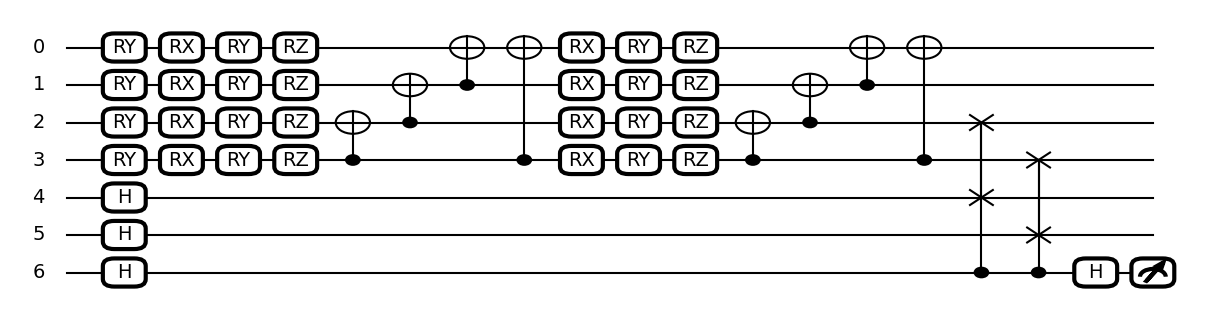

In [9]:
fig, ax = qml.draw_mpl(swap_test_on_adj_decoder)(X_train_clean[0], dec_dagger_params0)
fig.set_size_inches(12, 3)

In [10]:
# Stage 1
dec_dagger_params_trained, s1_hist = train_adjoint_decoder(
    dec_dagger_params0, X_train_clean, n_epochs=80, batch_size=8, lr=0.01
)

[S1] epoch 000 cost=0.082128
[S1] epoch 010 cost=0.096701
[S1] epoch 020 cost=0.076418
[S1] epoch 030 cost=0.081920
[S1] epoch 040 cost=0.075846
[S1] epoch 050 cost=0.083094
[S1] epoch 060 cost=0.075565
[S1] epoch 070 cost=0.075449
Stage 1 zakończony.


In [11]:
dev_z = qml.device(BACKEND, wires=n_qubits, shots=None)

@qml.qnode(dev_z, interface="autograd")
def adjoint_decoder_z_readout(x, params):
    adjoint_decoder_ansatz(params, x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

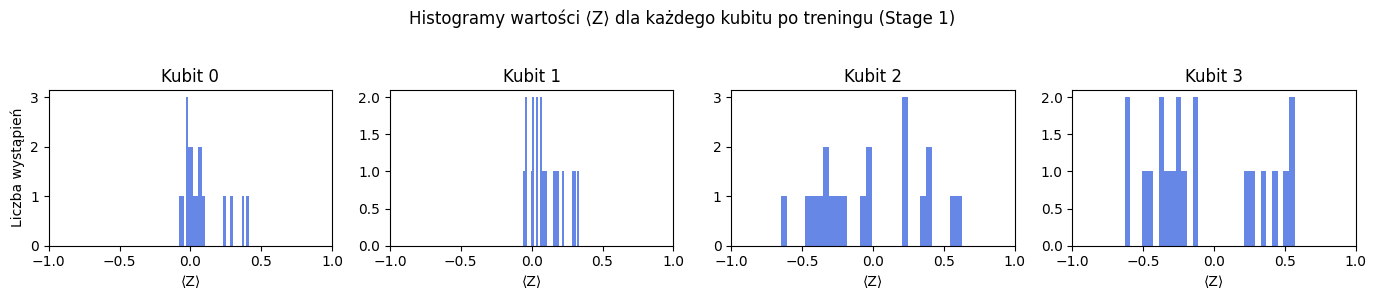

In [12]:
Z_vals = []
for x in X_val_clean:
    z = np.array(adjoint_decoder_z_readout(x, dec_dagger_params_trained), dtype=float)
    Z_vals.append(z)
Z_vals = np.array(Z_vals) 

plt.figure(figsize=(14, 3))
for i in range(n_qubits):
    plt.subplot(1, n_qubits, i+1)
    plt.hist(Z_vals[:, i], bins=30, color='royalblue', alpha=0.8)
    plt.title(f"Kubit {i}")
    plt.xlabel("⟨Z⟩")
    if i == 0:
        plt.ylabel("Liczba wystąpień")
    plt.xlim(-1, 1)
plt.suptitle("Histogramy wartości ⟨Z⟩ dla każdego kubitu po treningu (Stage 1)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

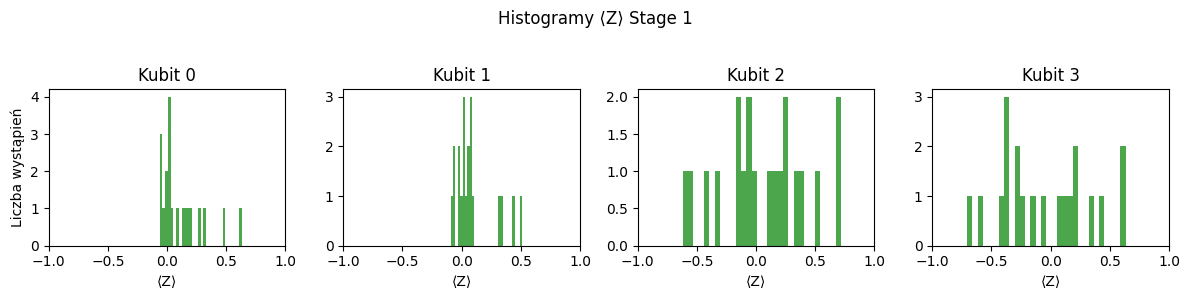

In [13]:
Z_test = []
for x in X_test:
    z = np.array(adjoint_decoder_z_readout(x, dec_dagger_params_trained), dtype=float)
    Z_test.append(z)
Z_test = np.array(Z_test)

plt.figure(figsize=(12, 3))
for i in range(n_qubits):
    plt.subplot(1, n_qubits, i+1)
    plt.hist(Z_test[:, i], bins=30, color='green', alpha=0.7)
    plt.title(f"Kubit {i}")
    plt.xlabel("⟨Z⟩")
    if i == 0:
        plt.ylabel("Liczba wystąpień")
    plt.xlim(-1, 1)
plt.suptitle("Histogramy ⟨Z⟩ Stage 1")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
# ==== STAGE 2: trenujemy ENCODER latent↔latent (noisy vs clean_ref) ====
dev_s2 = qml.device(BACKEND, wires=2*n_qubits + 1, shots=None)

@qml.qnode(dev_s2, interface="autograd")
def swap_test_encoder_latent(x_noisy, x_clean, enc_params, dec_dagger_params):
    encoder = list(range(n_qubits))                     # blok encodera
    ref  = list(range(n_qubits, 2*n_qubits))         # blok referencyjny
    anc  = 2*n_qubits

    encoder_ansatz(enc_params, x_noisy, wires=encoder)
    adjoint_decoder_ansatz(dec_dagger_params, x_clean, wires=ref)

    qml.Hadamard(wires=anc)
    for i in range(n_latent):
        qml.CSWAP(wires=[anc, encoder[i], ref[i]])         # SWAP tylko latentów
    qml.Hadamard(wires=anc)
    return qml.probs(wires=anc)

def s2_cost(enc_params, X_noisy_b, X_clean_b, dec_dagger_params):
    acc = pnp.array(0.0)
    for xn, xc in zip(X_noisy_b, X_clean_b):
        p0 = swap_test_encoder_latent(xn, xc, enc_params, dec_dagger_params)[0]
        acc = acc + (1.0 - p0)
    return acc / len(X_noisy_b)

info = {"scale_low": 0.2, "scale_high": 0.8}

def train_encoder_with_sidekick_dyn_noise(enc_params_init, X_clean,
                                          dec_dagger_params, noise_level,
                                          n_epochs=80, batch_size=8, lr=0.01, seed=0):
    params = pnp.array(enc_params_init, requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=lr)
    hist = []
    rng = np.random.default_rng(seed)

    low, high = info["scale_low"], info["scale_high"]
    sigma = noise_level * (high - low)  

    for ep in range(n_epochs):
        idx = rng.permutation(len(X_clean))
        Xc = X_clean[idx]
        s = 0.0; nb = 0
        for i in range(0, len(Xc), batch_size):
            Xcb = Xc[i:i+batch_size]                         # clean batch
            Xnb = ts_add_noise(Xcb, noise=sigma, low=low, high=high)  # noisy batch

            params, c = opt.step_and_cost(
                lambda p: s2_cost(p, Xnb, Xcb, dec_dagger_params), params
            )
            s += float(c); nb += 1
        hist.append(s/nb)
        if ep % 10 == 0:
            print(f"[S2 dyn-noise] epoch {ep:03d} cost={hist[-1]:.6f}")
    print("Stage 2 (dynamic Gaussian noise) zakończony.")
    return params, hist

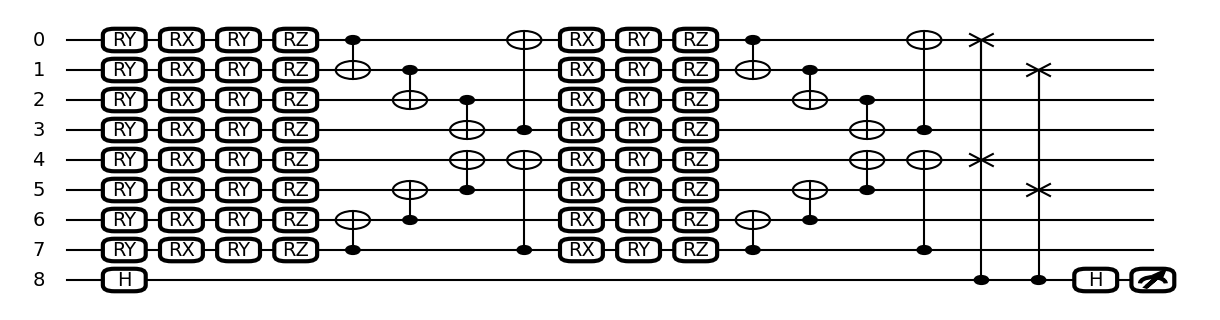

In [15]:
fig, ax = qml.draw_mpl(swap_test_encoder_latent)(X_train_noisy[0], X_train_clean[0], enc_params0, dec_dagger_params0)
fig.set_size_inches(12, 3)

In [16]:
# Stage 2
enc_params_trained, s2_hist = train_encoder_with_sidekick_dyn_noise(
    enc_params0, X_train_clean,  
    dec_dagger_params_trained,
    noise_level=0.10,           
    n_epochs=80, batch_size=8, lr=0.01
)

[S2 dyn-noise] epoch 000 cost=0.123613
[S2 dyn-noise] epoch 010 cost=0.128853
[S2 dyn-noise] epoch 020 cost=0.106984
[S2 dyn-noise] epoch 030 cost=0.121080
[S2 dyn-noise] epoch 040 cost=0.105499
[S2 dyn-noise] epoch 050 cost=0.121686
[S2 dyn-noise] epoch 060 cost=0.107665
[S2 dyn-noise] epoch 070 cost=0.105176
Stage 2 (dynamic Gaussian noise) zakończony.


In [17]:
dev_probe = qml.device(BACKEND, wires=n_qubits, shots=None)

@qml.qnode(dev_probe, interface="autograd")
def encoder_z_readout(x, enc_params):
    encoder_ansatz(enc_params, x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [18]:
@qml.qnode(dev_probe, interface="autograd")
def adjoint_decoder_z_readout(x, dec_params):
    adjoint_decoder_ansatz(dec_params, x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

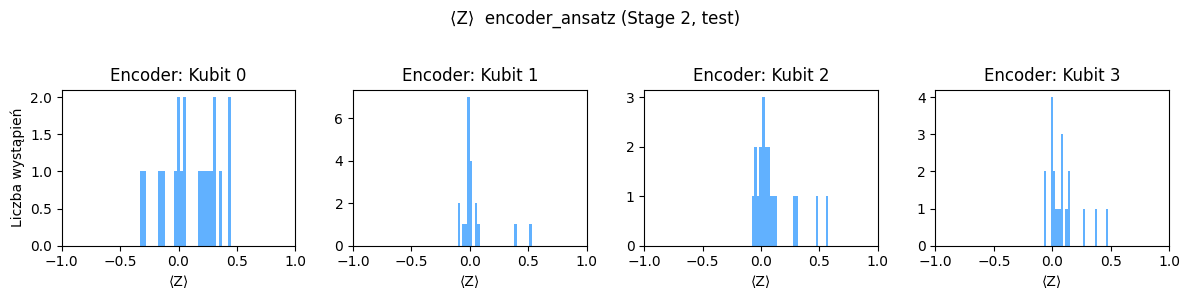

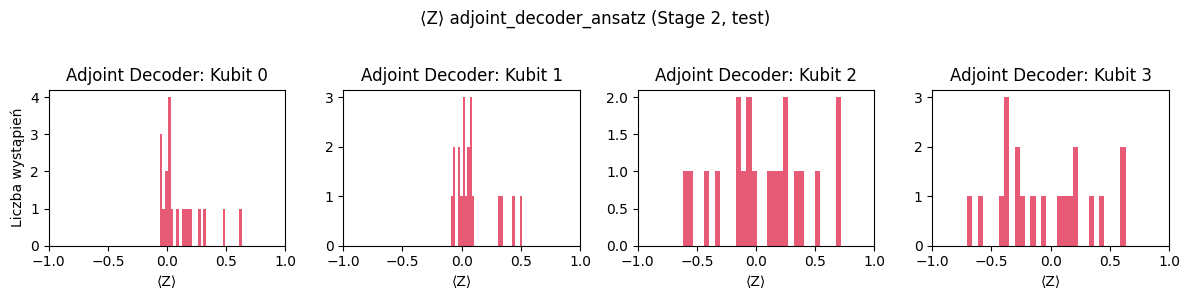

In [19]:
Z_enc = []
for x in X_test:
    z = encoder_z_readout(x, enc_params_trained)
    Z_enc.append(z)
Z_enc = np.array(Z_enc)

plt.figure(figsize=(12, 3))
for i in range(n_qubits):
    plt.subplot(1, n_qubits, i+1)
    plt.hist(Z_enc[:, i], bins=30, color='dodgerblue', alpha=0.7)
    plt.title(f"Encoder: Kubit {i}")
    plt.xlabel("⟨Z⟩")
    if i == 0: plt.ylabel("Liczba wystąpień")
    plt.xlim(-1, 1)
plt.suptitle("⟨Z⟩  encoder_ansatz (Stage 2, test)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Z_dec = []
for x in X_test:
    z = adjoint_decoder_z_readout(x, dec_dagger_params_trained)
    Z_dec.append(z)
Z_dec = np.array(Z_dec)

plt.figure(figsize=(12, 3))
for i in range(n_qubits):
    plt.subplot(1, n_qubits, i+1)
    plt.hist(Z_dec[:, i], bins=30, color='crimson', alpha=0.7)
    plt.title(f"Adjoint Decoder: Kubit {i}")
    plt.xlabel("⟨Z⟩")
    if i == 0: plt.ylabel("Liczba wystąpień")
    plt.xlim(-1, 1)
plt.suptitle("⟨Z⟩ adjoint_decoder_ansatz (Stage 2, test)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [20]:
# ==== STAGE 3: odczyt i rekonstrukcja całego szeregu ====
dev_rec = qml.device(BACKEND, wires=n_qubits, shots=None)

@qml.qnode(dev_rec, interface="autograd")
def full_qae_readout(x_noisy, enc_params, dec_params):
    encoder_ansatz(enc_params, x_noisy)
    decoder_ansatz(dec_params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def z_to_value(z_vec):
    z = np.clip(np.asarray(z_vec, dtype=float), -1.0, 1.0)
    val01 = np.arccos(z) / np.pi
    return scale_low + val01 * (scale_high - scale_low)

def reconstruct_batch(X_noisy, enc_params, dec_params):
    Y = []
    for x in X_noisy:
        z = np.array(full_qae_readout(x, enc_params, dec_params), dtype=float)
        Y.append(z_to_value(z))
    return np.array(Y)

def mse(a,b): return float(np.mean((a-b)**2))


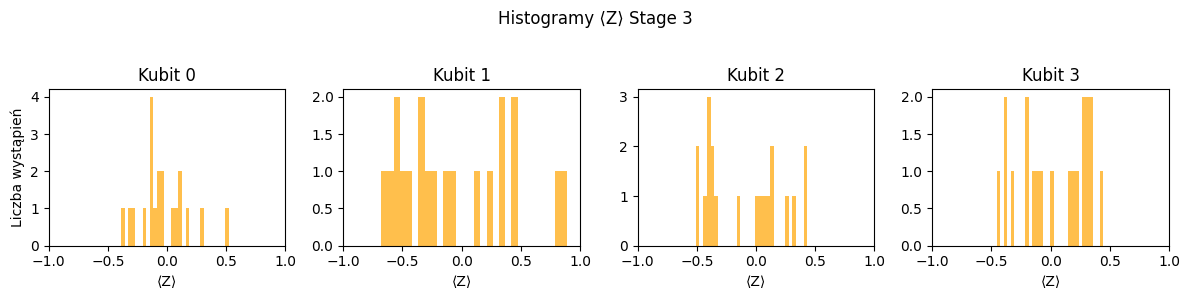

In [21]:

@qml.qnode(dev_rec, interface="autograd")
def full_qae_readout(x_noisy, enc_params, dec_params):
    encoder_ansatz(enc_params, x_noisy)
    decoder_ansatz(dec_params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


Z_vals = []
for x in X_val_noisy:
    z = full_qae_readout(x, enc_params_trained, dec_dagger_params_trained)
    Z_vals.append(z)
Z_vals = np.array(Z_vals) 

plt.figure(figsize=(12, 3))
for i in range(n_qubits):
    plt.subplot(1, n_qubits, i+1)
    plt.hist(Z_vals[:, i], bins=30, color='orange', alpha=0.7)
    plt.title(f"Kubit {i}")
    plt.xlabel("⟨Z⟩")
    if i == 0:
        plt.ylabel("Liczba wystąpień")
    plt.xlim(-1, 1)
plt.suptitle("Histogramy ⟨Z⟩ Stage 3")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

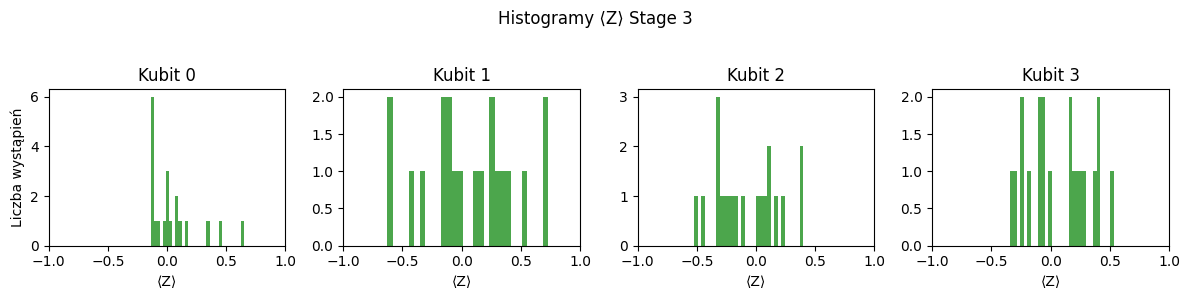

In [22]:
Z_test = []
for x in X_test:
    z = full_qae_readout(x, enc_params_trained, dec_dagger_params_trained)
    Z_test.append(z)
Z_test = np.array(Z_test)  

plt.figure(figsize=(12, 3))
for i in range(n_qubits):
    plt.subplot(1, n_qubits, i+1)
    plt.hist(Z_test[:, i], bins=30, color='green', alpha=0.7)
    plt.title(f"Kubit {i}")
    plt.xlabel("⟨Z⟩")
    if i == 0:
        plt.ylabel("Liczba wystąpień")
    plt.xlim(-1, 1)
plt.suptitle("Histogramy ⟨Z⟩ Stage 3")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [1]:
# Y_val_hat = reconstruct_batch(X_val_noisy, enc_params_trained, dec_dagger_params_trained)
# print("[VAL]  MSE noisy→clean :", mse(X_val_noisy, X_val_clean))
# print("[VAL]  MSE recon→clean :", mse(Y_val_hat,   X_val_clean))


# # ==== REKONSTRUKCJA CAŁEGO SZEREGU ====
# y_full = y.copy()
# X_full_noisy = np.stack([y_full[i:i+window_size] for i in range(0, len(y_full)-window_size+1, stride)])
# Y_hat_windows = reconstruct_batch(X_full_noisy, enc_params_trained, dec_dagger_params_trained)
# y_recon_full  = overlap_average_equal(Y_hat_windows, len(y_full), window_size, stride)

# print("[FULL] MSE recon vs clean:", mse(y_recon_full, y_full))

# plt.figure(figsize=(12,4))
# plt.title("Rekonstrukcja całego szeregu Mackey-Glass")
# plt.plot(y_full,       label="clean (target)", linewidth=1.0)
# plt.plot(y_recon_full, label="reconstruction", linewidth=1.6)
# plt.xlabel("zakres"); plt.ylabel("wartość"); plt.legend(); plt.tight_layout(); plt.show()


In [2]:
# y_full_clean = y.copy()
# y_full_noisy = ts_add_noise(y_full_clean, noise=noise, low=scale_low, high=scale_high)

# X_full_noisy = np.stack([
#     y_full_noisy[i:i+window_size]
#     for i in range(0, len(y_full_noisy)-window_size+1, stride)
# ])

# Y_hat_windows = reconstruct_batch(X_full_noisy, enc_params_trained, dec_dagger_params_trained)
# y_recon_full  = overlap_average_equal(Y_hat_windows, len(y_full_clean), window_size, stride)

# print("[FULL denoise] MSE noisy → clean :", mse(y_full_noisy,  y_full_clean))
# print("[FULL denoise] MSE recon → clean :", mse(y_recon_full,  y_full_clean))

# plt.figure(figsize=(20,12))
# plt.title("Denoising całego szeregu Mackey-Glass")
# plt.plot(y_full_clean, label="clean (target)", linewidth=1.0)
# plt.plot(y_full_noisy, marker ='o', linestyle="", label="noisy", linewidth=1.0, alpha=0.7)
# plt.plot(y_recon_full, linestyle='--',label="reconstruction", linewidth=1.6)
# plt.xlabel("zakres"); plt.ylabel("wartość"); plt.legend(); plt.tight_layout(); plt.show()


[FULL denoise] MSE noisy → clean : 0.010079436829058566
[FULL denoise] MSE recon → clean : 0.011072596635066925


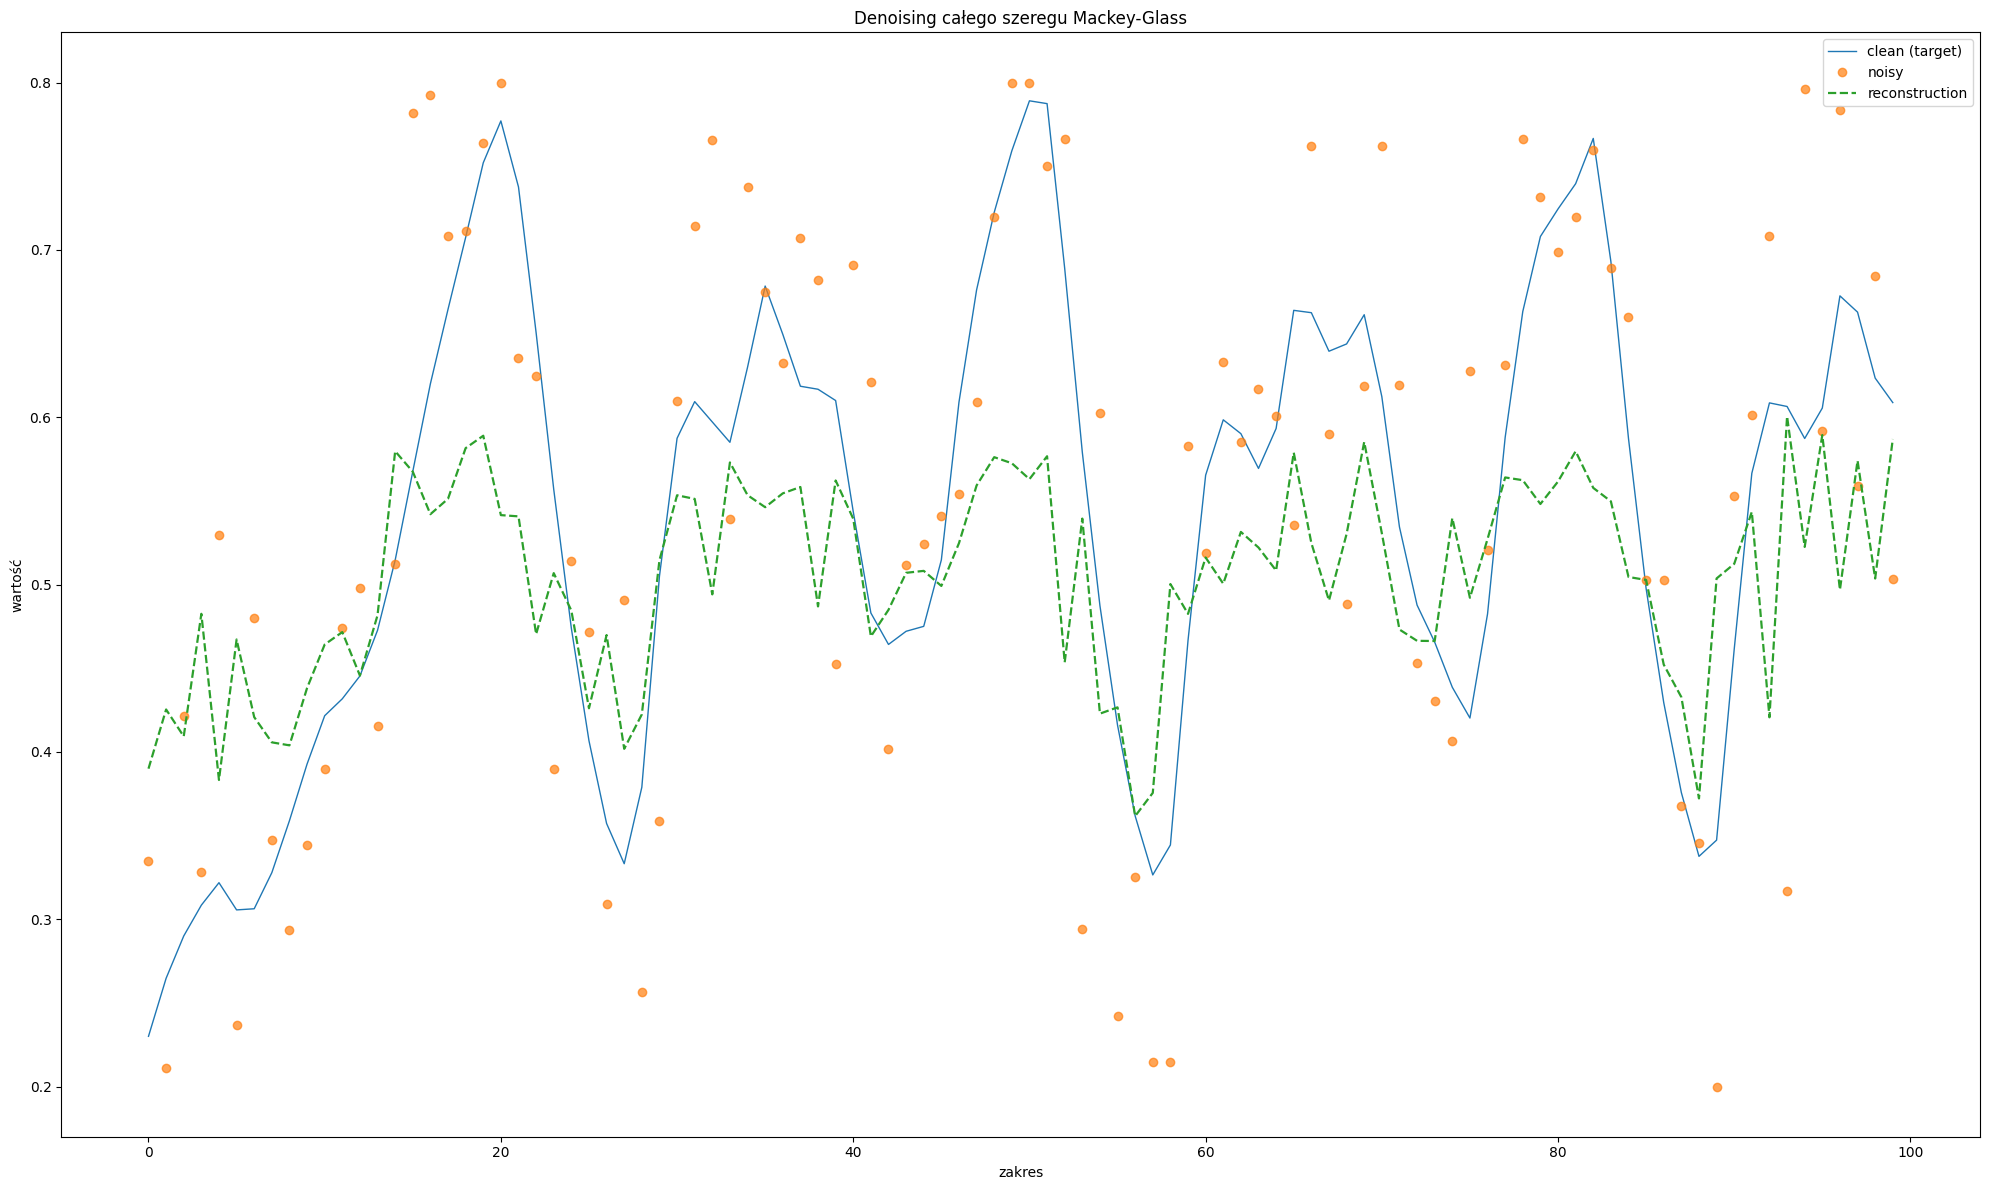

In [39]:
y_full_clean = y.copy()
y_full_noisy = ts_add_noise(y_full_clean, noise=noise, low=scale_low, high=scale_high)

X_full_noisy = np.stack([
    y_full_noisy[i:i+window_size]
    for i in range(0, len(y_full_noisy)-window_size+1, stride)
])

Y_hat_windows = reconstruct_batch(X_full_noisy, enc_params_trained, dec_dagger_params_trained)
y_recon_full  = overlap_average_weighted(Y_hat_windows, len(y_full_clean), window_size, stride)

print("[FULL denoise] MSE noisy → clean :", mse(y_full_noisy,  y_full_clean))
print("[FULL denoise] MSE recon → clean :", mse(y_recon_full,  y_full_clean))

plt.figure(figsize=(20,12))
plt.title("Denoising całego szeregu Mackey-Glass")
plt.plot(y_full_clean, label="clean (target)", linewidth=1.0)
plt.plot(y_full_noisy, marker ='o', linestyle="", label="noisy", linewidth=1.0, alpha=0.7)
plt.plot(y_recon_full, linestyle='--',label="reconstruction", linewidth=1.6)
plt.xlabel("zakres"); plt.ylabel("wartość"); plt.legend(); plt.tight_layout(); plt.show()
